In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import multiprocessing
import seaborn as sns
import os
import time
import random
import pickle
import librosa
import parmap
import numba
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

t_p = 'd://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/Training/[T]라벨링데이터.zip'
v_p = 'd://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/Validation/[V]라벨링데이터.zip'

c:\Users\JANG JAE YOUNG\.conda\envs\dddd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# json 파일 경로 모음
t_json = []
v_json = []

with zipfile.ZipFile(t_p, 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        if fileName.endswith('.json') == True:
            t_json.append(fileName)

with zipfile.ZipFile(v_p, 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        if fileName.endswith('.json') == True:
            v_json.append(fileName)

In [3]:
# 특정파일 추춯에 접근하기 위한 경로 재설정
for k,i in enumerate(t_json):
    t_json[k] = 't_json/' + i
for k,i in enumerate(v_json):
    v_json[k] = 'v_json/' + i

In [4]:
# 불러온 데이터를 pickle로 저장 후 불러와서 사용
with open('arr.pickle', 'rb') as f:
	data = pickle.load(f)

# 총 데이터 개수
len(data)

1130811

In [5]:
# speakname 속성이 있는 것을 발견
# 총 795개
# haveon0o,notprovided, pb_0207의 고유값을 가지고 있는 것을 확인
lis_35 = [] 
for i in data:
    if len(i) == 35:
        lis_35.append(i)

lis_35_df = pd.DataFrame(data=lis_35)
print(len(lis_35))
lis_35_df[17].unique()

795


array(['HAHEON0O', 'PB_0207', 'NotProvided'], dtype=object)

In [6]:
# 총 데이터 1130811 중 795개 0.1%도 되지 않아 제거하고 탐색을 진행
copy_data = data.copy()
for i in data:
    if i in lis_35:
        copy_data.remove(i)
print(len(copy_data))

1130016


In [7]:
cols = ['Language', 'Version', 'ApplicationCategory', 'NumberOfSpeaker', 'NumberOfUtterance',
        'DataCategory', 'RecordingDate', 'FillingDate', 'RevisionHistory', 'Distributor',
        'SamplingRate', 'ByteOrder', 'EncodingLaw', 'NumberOfBit', 'NumberOfChannel',
        'SignalToNoiseRatio', 'LabelText','Gender', 'Age', 'Region', 'Dialect', 'RecordingEnviron',
        'NoiseEnviron', 'RecordingDevice', 'FileCategory', 'FileName', 'DirectoryPath', 'HeaderSize',
        'FileLength', 'FileFormat', 'NumberOfRepeat', 'TimeInterval','Distance','QualityStatus']

In [8]:
df = pd.DataFrame(data= copy_data,columns=cols)
df.head()

,Language,Version,ApplicationCategory,NumberOfSpeaker,NumberOfUtterance,DataCategory,RecordingDate,FillingDate,RevisionHistory,Distributor,...,FileCategory,FileName,DirectoryPath,HeaderSize,FileLength,FileFormat,NumberOfRepeat,TimeInterval,Distance,QualityStatus
0,KOR,N/A,N/A,N/A,N/A,mariaDB,2021-01-15 12:50:48,N/A,N/A,Mediazen,...,Audio,PE_0073-16716-01-03-F-09-A.wav,/nia/metrixB/data/PE_0073,44,5.22,PCM,1,0,30,Good
1,KOR,N/A,N/A,N/A,N/A,mariaDB,2021-01-15 11:51:56,N/A,N/A,Mediazen,...,Audio,PE_0073-16558-01-03-F-09-A.wav,/nia/metrixB/data/PE_0073,44,3.84,PCM,1,0,30,Good
2,KOR,N/A,N/A,N/A,N/A,mariaDB,2021-01-15 12:35:44,N/A,N/A,Mediazen,...,Audio,PE_0073-16697-01-03-F-09-A.wav,/nia/metrixB/data/PE_0073,44,5.04,PCM,1,0,30,Good
3,KOR,N/A,N/A,N/A,N/A,mariaDB,2021-01-15 11:30:45,N/A,N/A,Mediazen,...,Audio,PE_0073-16496-01-03-F-09-A.wav,/nia/metrixB/data/PE_0073,44,5.70,PCM,1,0,30,Good
4,KOR,N/A,N/A,N/A,N/A,mariaDB,2021-01-15 11:51:04,N/A,N/A,Mediazen,...,Audio,PE_0073-16555-01-03-F-09-A.wav,/nia/metrixB/data/PE_0073,44,10.08,PCM,1,0,30,Good


In [9]:
df_df = df[['FileName','LabelText']]
df_df.head()

,FileName,LabelText
0,PE_0073-16716-01-03-F-09-A.wav,매일 저녁 먹을 때 와인 한 잔씩 마셔요.
1,PE_0073-16558-01-03-F-09-A.wav,안 하려고 노력하는데요.
2,PE_0073-16697-01-03-F-09-A.wav,전자 담배로 바꾼 기간도 포함되나요?
3,PE_0073-16496-01-03-F-09-A.wav,아예 잠이 안 오는 게 제일 큰 문제에요.
4,PE_0073-16555-01-03-F-09-A.wav,되게 잘 자요. 베개에 머리를 대자마자 자거든요. 일곱 시간은 기본적으로 자요.


In [10]:
# 라벨 빈도수가 20미만이 데이터를 잘라내기
label_series = df_df.groupby('LabelText').size()
for i,v in zip(label_series.index,label_series.values):
    if v < 20:
        label_series = label_series.drop(i)
label_series[:5]

LabelText
가게를 운영해요.                          23
가격이 비싸지 않나요?                       20
가고 싶긴 한데 움직이는 게 불편해요.              20
가고 싶어도 못 가서 일 년은 외국 땅 밟지도 못했어요.    31
가고 싶었는데 취소했어요.                     22
dtype: int64

In [11]:
label_lis = list(label_series.index)
label_lis[:5]

['가게를 운영해요.',
 '가격이 비싸지 않나요?',
 '가고 싶긴 한데 움직이는 게 불편해요.',
 '가고 싶어도 못 가서 일 년은 외국 땅 밟지도 못했어요.',
 '가고 싶었는데 취소했어요.']

In [12]:
label_series['매일 저녁 먹을 때 와인 한 잔씩 마셔요.']

37

In [13]:
# pandas DataFrame이나 Series에 isin() 메소드를 사용하면 isin() 메소드 안의 값이 들어 있으면,
# 즉 소속이 되어 있으면 (membership) True를, 들어있지 않으면 False 를 반환합니다.
# 이처럼 조건 값의 소속 여부를 Boolean 값으로 반환해주는 점을 이용하여, 특정 값이 들어있는 행을 DataFrame, Series에서 indexing 해올 수 있습니다.
# 위의 예제 'df' DataFrame의 'id' 칼럼에서 'b', 'e', 'k' 값이 들어있는 행 전체를 가져와 보겠습니다.
over_20_df = df_df[df_df['LabelText'].isin(label_lis)]
over_20_df

,FileName,LabelText
0,PE_0073-16716-01-03-F-09-A.wav,매일 저녁 먹을 때 와인 한 잔씩 마셔요.
1,PE_0073-16558-01-03-F-09-A.wav,안 하려고 노력하는데요.
2,PE_0073-16697-01-03-F-09-A.wav,전자 담배로 바꾼 기간도 포함되나요?
3,PE_0073-16496-01-03-F-09-A.wav,아예 잠이 안 오는 게 제일 큰 문제에요.
4,PE_0073-16555-01-03-F-09-A.wav,되게 잘 자요. 베개에 머리를 대자마자 자거든요. 일곱 시간은 기본적으로 자요.
...,...,...
1130011,HA_1578-7722-01-02-F-06-A.wav,수액을 맞으면 식사를 안 해도 괜찮고 주사도 수액 통해서 맞으면 덜 아파요.
1130012,HA_1578-7504-01-02-F-06-A.wav,아니요 최근에 생긴 흉터만 보여주시면 될 것 같습니다.
1130013,HA_1578-7518-01-02-F-06-A.wav,어떤 걸 드시는지 알아야 설명드릴 수 있습니다.
1130014,HA_1578-7821-01-02-F-06-A.wav,네 혹시나 수혈이 필요한 상황이 있을 수 있어 물어보는 거예요.


In [14]:
over_20_df.groupby('LabelText').size().sort_values()[23300:23357]

LabelText
마지막에 해외 나가신 게 언제인가요?                 90
최근에 일 년 동안 해외 체류하신 적 있어요?            90
결핵 수치가 높으신가요?                        90
얼마나 피로하세요?                           90
토하셨나요?                               91
네.                                   91
배가 아프신가요?                            91
특정한 대상에 알레르기가 있나요?                   91
통증이 오는 곳이 있나요?                       91
결핵 병력 있으신가요?                         91
기존에 질환이나 질병이 있으셨나요?                  92
음식과 약물 말고 어떤 것이 알레르기를 일으키나요?         93
속이 계속 메슥거리는지 궁금합니다.                  94
딱히요.                                 94
누우면 바로 잠에 드는 편인가요?                   97
고혈압인 것을 안 게 언제부터죠?                   98
여태껏 체크했던 것 이외의 알레르기가 있다면 말해주세요.      99
아프기 시작한 게 언제부터예요?                    99
결핵으로 치료받고 계시나요?                      99
힘이 많이 달린다는 느낌은 없으시고요?                99
최근 일 년 내에 해외에 나갔다 들어오셨나요?            99
어떤 식으로 통증이 있으신지 설명해 주실 수 있나요?       100
소화불량이 얼마나 오래됐나요?                    100
이 음식에서 알레르기 반응이 나타나나요?              100
어떤 약물에 알레르기가 있었나요?            

In [15]:
len(over_20_df['LabelText'].unique())

23357

In [16]:
len(over_20_df)

894269

In [17]:
# index 재설정
# over_20_df['inx'] = [i for i in range(len(over_20_df))]
# over_20_df.loc[:,'inx'] = [i for i in range(len(over_20_df))]
# reset_index ( drop= index로 사용한 열을 삭제할건지 (디폴트)냅둘건지,
# inplace= (디폴트)원본을 사용할건지 바뀐df를 쓸건지)
over_20_df.reset_index(drop=True,inplace=True)


In [21]:
over_20_df

,FileName,LabelText
0,PE_0073-16716-01-03-F-09-A.wav,매일 저녁 먹을 때 와인 한 잔씩 마셔요.
1,PE_0073-16558-01-03-F-09-A.wav,안 하려고 노력하는데요.
2,PE_0073-16697-01-03-F-09-A.wav,전자 담배로 바꾼 기간도 포함되나요?
3,PE_0073-16496-01-03-F-09-A.wav,아예 잠이 안 오는 게 제일 큰 문제에요.
4,PE_0073-16555-01-03-F-09-A.wav,되게 잘 자요. 베개에 머리를 대자마자 자거든요. 일곱 시간은 기본적으로 자요.
...,...,...
894264,HA_1578-7722-01-02-F-06-A.wav,수액을 맞으면 식사를 안 해도 괜찮고 주사도 수액 통해서 맞으면 덜 아파요.
894265,HA_1578-7504-01-02-F-06-A.wav,아니요 최근에 생긴 흉터만 보여주시면 될 것 같습니다.
894266,HA_1578-7518-01-02-F-06-A.wav,어떤 걸 드시는지 알아야 설명드릴 수 있습니다.
894267,HA_1578-7821-01-02-F-06-A.wav,네 혹시나 수혈이 필요한 상황이 있을 수 있어 물어보는 거예요.


(array([23., 20., 20., ..., 81., 23., 22.]),
 array([0.00000000e+00, 9.99957186e-01, 1.99991437e+00, ...,
        2.33540001e+04, 2.33550000e+04, 2.33560000e+04]),
 <BarContainer object of 23357 artists>)

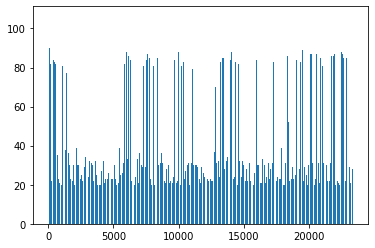

In [19]:
le = LabelEncoder()
plt.hist(le.fit_transform(over_20_df['LabelText']),bins=23357,rwidth=0.7)

In [40]:
label_df = list(df['LabelText'])
filename_df = list(df['FileName'])

for i in tqdm(label_df):
    if i not in label_lis:
        label_df.remove(i)
len(df_df)

 89%|████████▊ | 1000126/1130016 [28:32<03:42, 584.17it/s] 


1130016

In [19]:
len(label_df)

NameError: name 'label_df' is not defined

In [ ]:
t_zip = 'D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/Training/비대면 진료를 위한 의료진 및 환자 음성/Training'
v_zip = 'D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/Training/비대면 진료를 위한 의료진 및 환자 음성/Validation'


In [18]:
audio_path = 'D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/audio'
patient_path = 'C://Users/JANG JAE YOUNG/pe'

In [48]:
au = os.listdir(audio_path)
au

['[T원천]의료진_간호사_1',
 '[T원천]의료진_간호사_2',
 '[T원천]의료진_간호사_3',
 '[T원천]의료진_간호사_4',
 '[T원천]의료진_의사_1',
 '[T원천]의료진_의사_2',
 '[T원천]의료진_의사_3']

In [ ]:
from pathlib import Path
 
def listdirs(audio_path):
    for path in Path(audio_path).iterdir():
        if path.is_dir():
            print(path[20:])
            # if path.
                # print('dong')
                # break
            listdirs(path)
 
listdirs(audio_path)

In [21]:
wav_lis = []
def read_all(root,):
    for path in Path(root).iterdir():
        # path가 디렉토리일시 재귀함수로 하위 디렉토리 입장
        # path.is_dir(), path.is_file() - return bool
        if path.is_dir():
            read_all(root)
        
        # path가 파일이면 wav리스트에 저장
        elif path.is_file():
            if str(path)[62:] == d:
                arr, _ = librosa.load(str(path),sr=48000)
                wav_lis.append(arr)
                #wav_lis.append(str(path))


In [53]:
from pathlib import Path
c = 0
bin = []
def listdirs(rootdir):
    for path in Path(rootdir).iterdir():
            #print(path)
        if path.is_dir():
            #print(path)
            listdirs(path)
        elif path.is_file():
            bin.append(str(path))

    return bin
a = listdirs(patient_path)

In [ ]:
from time import sleep
pbar = tqdm(range(100))
for epoch in pbar :
    sleep(1)
    if epoch % 10 == 0 :
        log.info(f"check")
    pbar.set_postfix({'logging' : epoch})

In [21]:
a[0][37:51]

NameError: name 'a' is not defined

In [56]:
# ha_hb_wav pickle 저장
with open('pa_wav.pickle', 'wb') as f:
    pickle.dump(a, f)

In [19]:
# wav load
with open("ha_hb_wav.pickle", 'rb') as f:
    hahb = pickle.load(f)

with open("pa_wav.pickle", 'rb') as f:
    pa = pickle.load(f)

In [67]:
d = []
for i in hahb:
    if i[63:] in ['HA_1578-7722-01-02-F-06-A.wav']:
        print(i[63:])
        a, _ = librosa.load(i,sr=48000)
        d.append(a)
d

HA_1578-7722-01-02-F-06-A.wav


[array([0.        , 0.        , 0.        , ..., 0.00143433, 0.00119019,
        0.00149536], dtype=float32)]

In [50]:
pa[0][47:]

'PA_0016-10-01-03-M-09-A.wav'

In [51]:
over_20_df['FileName'][0]

'PE_0073-16716-01-03-F-09-A.wav'

In [52]:
hahb[0]

'D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/audio/[T원천]의료진_간호사_1/1/HA_0010/HA_0010-1-01-02-M-04-A.wav'

In [23]:
wav_arr = []
for i in tqdm(hahb):
    if i[63:] in list(over_20_df['FileName']):
        wav_arr.append(i)
    
for i in tqdm(pa):
    if i[47:] in list(over_20_df['FileName']):
        wav_arr.append(i)

  0%|          | 22/571718 [00:04<33:48:13,  4.70it/s]


KeyboardInterrupt: 

In [71]:
wav_arr[:5]

[]

In [124]:
np.array(['111']).nbytes

12

In [55]:
ha_wav, sample_rate = librosa.load('D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/HA_0010-1-01-02-M-04-A.wav', sr=48000)
print('sample_rate:', sample_rate, ', audio shape:', ha_wav.shape)
print('length:', ha_wav.shape[0]/float(sample_rate), 'secs')

sample_rate: 48000 , audio shape: (158400,)
length: 3.3 secs


In [32]:
type(ha_wav)

numpy.ndarray

In [56]:
# wav file 1개의 storage 용량 및 npy 용량 비교
print(f'npy 용량 : {ha_wav.nbytes} bytes')

npy 용량 : 633600 bytes


In [74]:
ww = []
ww.append(ha_wav)
ww

[array([0.        , 0.        , 0.        , ..., 0.00393677, 0.00384521,
        0.00372314], dtype=float32)]

In [103]:
# process
from woker import Worker
if __name__ == '__main__':
    p1 = multiprocessing.Process(target=Worker,args=(1,))
    p2 = multiprocessing.Process(target=Worker,args=(2,))

    p1.start()
    p2.start()
    
    p1.join()
    p2.join()

    print("done")

done


In [83]:
bytearray(np.array(hahb))

In [97]:
# pool
from multiprocessing import Pool
from test import test

if __name__ ==  '__main__':
    num_processors = int(multiprocessing.cpu_count() * 0.7)
    p=Pool(processes = num_processors)
    start = time.time()
    output = p.map(test,over_20_df['FileName'][:500000],chunksize=68000)
    end = time.time()
    p.close()
    p.join()

print(end-start,output[:3])

0.5739984512329102 ['PE_0073-16716-01-03-F-09-A.wav', 'PE_0073-16558-01-03-F-09-A.wav', 'PE_0073-16697-01-03-F-09-A.wav']


In [75]:
d = []
start_1 = time.time()

for i in over_20_df['FileName'][:500000]:
    d.append(i)

end_1 = time.time()

print(end_1-start_1,d[:3])


0.17801165580749512 ['PE_0073-16716-01-03-F-09-A.wav', 'PE_0073-16558-01-03-F-09-A.wav', 'PE_0073-16697-01-03-F-09-A.wav']


In [2]:
y = [10, 20, 30]
 
try:
    index, x = map(int, input('인덱스와 나눌 숫자를 입력하세요: ').split())
    print(y[index] / x)
except ZeroDivisionError:    # 숫자를 0으로 나눠서 에러가 발생했을 때 실행됨
    print('숫자를 0으로 나눌 수 없습니다.')
except IndexError:           # 범위를 벗어난 인덱스에 접근하여 에러가 발생했을 때 실행됨
    print('잘못된 인덱스입니다.')

숫자를 0으로 나눌 수 없습니다.


In [19]:
list(over_20_df['FileName'])[:10]

['PE_0073-16716-01-03-F-09-A.wav',
 'PE_0073-16558-01-03-F-09-A.wav',
 'PE_0073-16697-01-03-F-09-A.wav',
 'PE_0073-16496-01-03-F-09-A.wav',
 'PE_0073-16555-01-03-F-09-A.wav',
 'PE_0073-16587-01-03-F-09-A.wav',
 'PE_0073-16609-01-03-F-09-A.wav',
 'PE_0073-16748-01-03-F-09-A.wav',
 'PE_0073-16782-01-03-F-09-A.wav',
 'PE_0073-16725-01-03-F-09-A.wav']

In [20]:
input_data = np.array_split(hahb,24)

In [30]:
len(input_data[0])

23822

In [31]:
from multiprocessing import Pool, cpu_count
from worker import Worker

# cpu 사용량 체크를 위한 라이브러리
# import psutil
hahb_arr = []


if __name__ ==  '__main__':

    #num_processors = int(multiprocessing.cpu_count() * 0.7)
    p=Pool(processes = 8)
    output = p.map(Worker,input_data[0],chunksize=197)

    # 더는 작업이 pool에 제출되지 않도록 한다. 모든 작업이 완료되면 프로세스 종료
    # terminate() - 계류 중인 작업을 완료하지 않고 즉시 프로세스 종료, pool 객체가 garbage 수집 될떄 terminate()즉시 호출
 
        # initialize a worker in the process pool
    def initialize_worker():
        # report a message
        print('Initializing worker...', flush=True)

    with Pool(8, initializer=initialize_worker) as pool:
        # issue tasks to the process pool
        for _ in range(4):
            pool.map(Worker)        
    #result = parmap.map(Worker, input_data[0], pm_pbar=True, pm_processes=8)
    
    #result_sum = sum(result,[])
    p.close()
    # 프로세스가 종료 될 때까지 기다림, 호출전에 반드시 close(), terminate()를 호출해야함
    p.join()
    # __del__ 메소드가 필요할꺼같다. 자원할당을 끊어줄수있는
    # (자원을 다시 주피터한테 다썼습는니다 라고 돌려줄 구문이필요)

    # worker 모듈의 정확한 정의를 확실히 하고 병렬처리방식을 완전히 수행시키는 것.
    # (chunksize = minibatch 확인, chunksize는 npy로는 몇개만 되고 cnn은 몇개만 되고... 작업에따라 달라지는 수치)

  0%|          | 0/23822 [00:52<?, ?it/s]


In [26]:
result[:3]

[array([0.        , 0.        , 0.        , ..., 0.00393677, 0.00384521,
        0.00372314], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ..., -0.00186157,
        -0.00167847, -0.00152588], dtype=float32),
 array([ 0.        ,  0.        ,  0.        , ..., -0.00039673,
        -0.00030518, -0.00021362], dtype=float32)]

In [16]:
c

1

In [83]:
import IPython.display as ipd  # To play sound in the notebook
fname = 'D://새 폴더/비대면 진료를 위한 의료진 및 환자 음성/audio/[T원천]의료진_간호사_3/3/HA_1977/HA_1977-9584-01-02-F-04-A.wav'   # Hi-hat
ipd.Audio(fname)

In [30]:
list(over_20_df['FileName'])[800000:800008]

['HA_1977-9584-01-02-F-04-A.wav',
 'HA_1977-9841-01-02-F-04-A.wav',
 'HA_1977-9982-01-02-F-04-A.wav',
 'HA_1977-9895-01-02-F-04-A.wav',
 'HA_1977-9570-01-02-F-04-A.wav',
 'HA_1977-9518-01-02-F-04-A.wav',
 'HA_1977-9881-01-02-F-04-A.wav',
 'HA_1977-9604-01-02-F-04-A.wav']

In [98]:
output[0][0][10000:11000]

IndexError: string index out of range

In [30]:
from multiprocessing import Pool, cpu_count


cpu_count()

8

In [25]:
output

[[], [], [], [], [], [], [], []]

In [54]:
output

In [145]:
global a


def s(d):
    a.append(d)
    return a

s(3)

[3, 3, 3, 3, 3, 3]